In [2]:
import os 
import pandas as pd

ITERATIONS = 1
columns=["dataset", "mtl", 'gamma', "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)



for idx, dataset in enumerate(['Coffee', 'Beef', 'GunPoint']):#,'Beef']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for classifier in ['conv_cas']: 

        for gamma in [0.75]:

            stl_results_fcn_i = pd.DataFrame(columns=columns)
            stl_results_res_i = pd.DataFrame(columns=columns)

            for itr in range(ITERATIONS): 
                fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/df_best_model.csv')
                fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/task1_df_metrics.csv')
                res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/df_best_model.csv')
                res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/task1_df_metrics.csv')

                

                fcn_vals = [fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                            fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
                res_vals = [res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                            res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 
                #Read STL results for FCN classifier
                if itr == 0:
                    stl_results_fcn_i.loc[idx] = [dataset,classifier,gamma] + fcn_vals
                    stl_results_res_i.loc[idx] = [dataset,classifier,gamma] + res_vals
                else:
                    stl_results_fcn_i.loc[idx, columns[3:]] += fcn_vals
                    stl_results_res_i.loc[idx, columns[3:]] += res_vals

            stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
            stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS

            stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
            stl_results_res = stl_results_res.append(stl_results_res_i)

C:\Users\boent\AppData\Local\Temp\ipykernel_44872\3895278636.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_44872\3895278636.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_res = stl_results_res.append(stl_results_res_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_44872\3895278636.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_44872\3895278636.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_resu

In [5]:
stl_results_fcn

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,Coffee,conv_cas,0.75,0.964286,0.964286,0.966667,76.499494
1,Beef,conv_cas,0.75,0.433333,0.341667,0.433333,55.202374
2,GunPoint,conv_cas,0.75,0.993333,0.993506,0.993243,72.842637


In [4]:
stl_results_res

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,Coffee,conv_cas,0.75,1.000000,1.000000,1.000000,117.392259
1,Beef,conv_cas,0.75,0.733333,0.803333,0.733333,96.577846
2,GunPoint,conv_cas,0.75,1.000000,1.000000,1.000000,113.296119


### Calculate Custom Metrics for Attribution Method


In [5]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'resnet' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

itr=5

gamma = 0.75
for idx, dataset in enumerate(['Beef']):#,'Beef']):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_ae_cas']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            print(model_type)
            ig_data_stl  = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_3/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/last_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            print("Calculate")
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_raw", task=1, experiment=3)
             # train and test data
            # 1,3 are the labels: 
            #print(ig_attributions) 
            for t in [1,3]:
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))[0,1]

                    pm2 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[t][ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-2]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l,"mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model.split("_")[-2]}'] =  {"model" : model , "pm1":pm1/l, "pm2": 
                                                                         pm2/l, "mm1":mm1/l,  "mm2": mm2/l}
                
        except Exception as e: 
            print(dataset,"error", e)
            pass


 #./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5
 
#G:\Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\experiment_3\fcn\fcn_mt_conv_cas_0.75_0\fcn_ig_raw\last_model.hdf5
#G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee//experiment_3/fcn/fcn_mt_conv_cas_0.75/fcn_ig_raw/last_model.hdf5
#./results\ucr\Beef\experiment_3\resnet\resnet_mt_conv_cas_0.75_4\resnet_ig_raw\last_model.hdf5
#./results/ucr/Coffee/experiment_3/resnet/resnet_mt_conv_cas_0.75_4/resnet_ig_raw/last_model.hdf5

Beef
fcn_mt_ae_cas
fcn
Calculate
1/1 [==============================] - 0s 83ms/step
pred 1 (30, 470)
1/1 [==============================] - 0s 398ms/step
pred 3 (30, 470)
1/1 [==============================] - 0s 101ms/step


In [3]:
import pandas as pd
pd.DataFrame(models_test).T

,mm1,mm2,model,pm1,pm2
Beef_conv,0.003115,0.005564,fcn_mt_conv_cas,0.256787,-0.325706


470 470


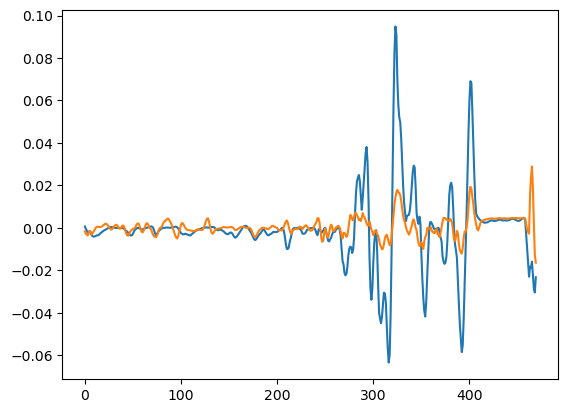

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


print(len(ig_data_stl[3][ts]),len(pred[1][ts].flatten()))
plt.plot(ig_data_stl[3][ts])
plt.plot(pred[1][ts].flatten())